# ASL Alphabet CNN

In [1]:
!pip install split-folders
%cd ~/tf

Defaulting to user installation because normal site-packages is not writeable
/home/rkuo/tf


/home/rkuo/.local/lib/python3.10/site-packages/IPython/core/magics/osm.py:393: UserWarning: using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/home/rkuo/.local/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import splitfolders
splitfolders.ratio("/home/rkuo/Datasets/ASL_alphabet/train", output="datasets/ASL_alphabet",
    seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False) # default values

Copying files: 87000 files [00:02, 31540.71 files/s]


In [3]:
train_dir = "datasets/ASL_alphabet/train"
val_dir   = "datasets/ASL_alphabet/val"
test_dir  = "datasets/ASL_alphabet/test"

## Prepare Dataset

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

batch_size = 16
target_size = (32,32) # dataset pic = 200x200

# horizontal_flip for left/right hand (mirror)
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)
val_datagen   = ImageDataGenerator(rescale=1./255, horizontal_flip=True)
test_datagen  = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=target_size,
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical',
        shuffle=True)

val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=target_size,
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical',
        shuffle=True)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical',
        shuffle=False)

2024-04-18 03:13:11.153181: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-18 03:13:11.174283: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-18 03:13:11.484737: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Found 69600 images belonging to 29 classes.
Found 8700 images belonging to 29 classes.
Found 8700 images belonging to 29 classes.


In [5]:
labels = list(train_generator.class_indices.keys())
print(labels)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


## Show Dataset

In [6]:
import os
import cv2
import matplotlib.pyplot as plt
TRAIN_PATH = train_dir
def sample_images(labels):
    # Create Subplots
    y_size = 12
    if(len(labels)<10):
        y_size = y_size * len(labels) / 10
    fig, axs = plt.subplots(len(labels), 9, figsize=(y_size, 13))

    for i, label in enumerate(labels):
        axs[i, 0].text(0.5, 0.5, label, ha='center', va='center', fontsize=8)
        axs[i, 0].axis('off')

        label_path = os.path.join(TRAIN_PATH, label)
        list_files = os.listdir(label_path)

        for j in range(8):
            img_label = cv2.imread(os.path.join(label_path, list_files[j]))
            img_label = cv2.cvtColor(img_label, cv2.COLOR_BGR2RGB)
            axs[i, j+1].imshow(img_label)
            axs[i, j+1].axis("off")

    # Title
    plt.suptitle("Sample Images in ASL Alphabet Dataset", x=0.55, y=0.92)

    # Show
    plt.show()

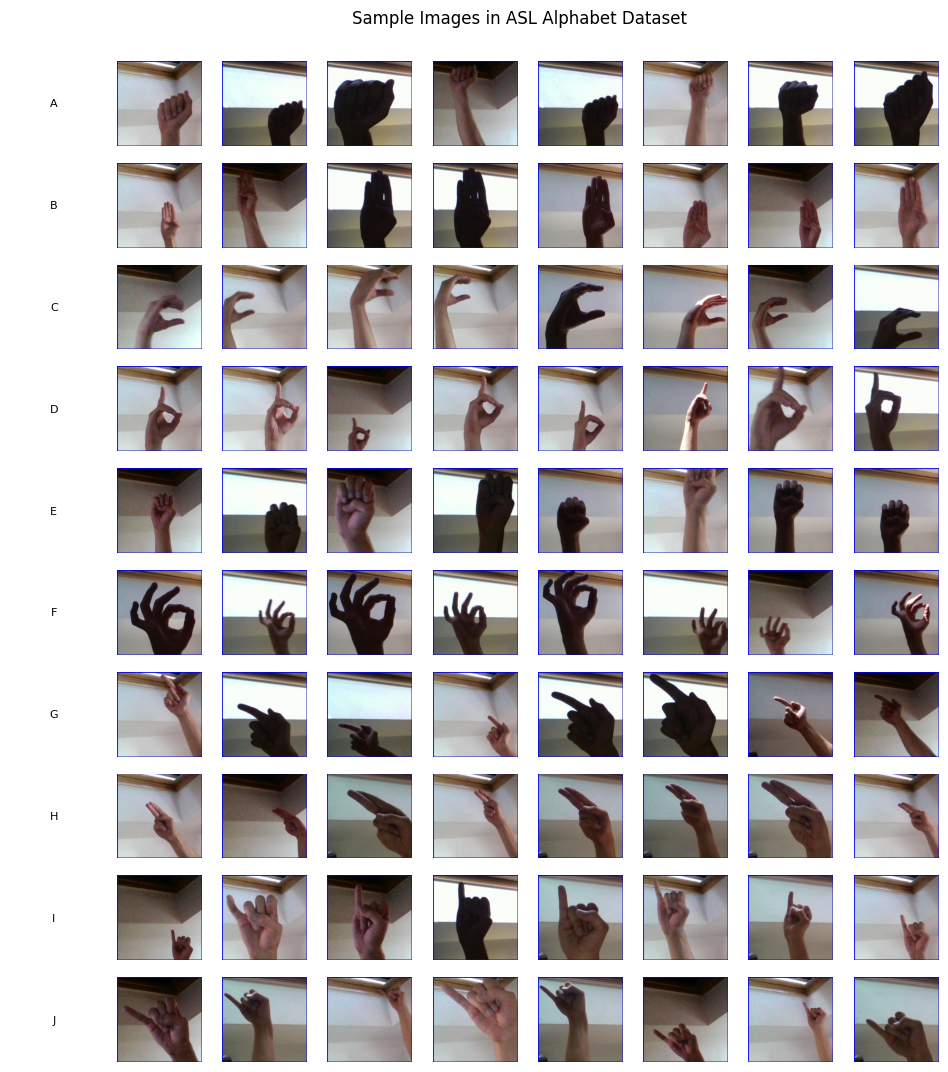

In [7]:
sample_images(labels[:10])

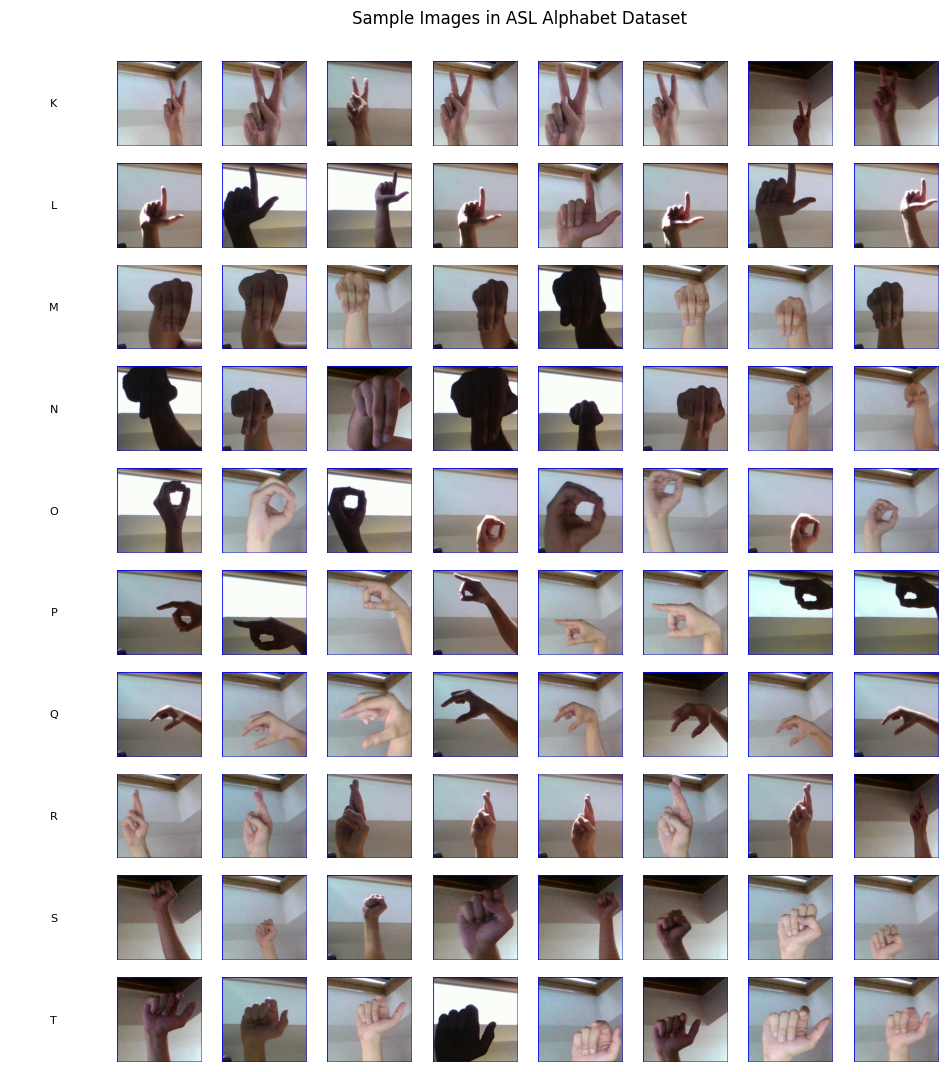

In [8]:
sample_images(labels[10:20])

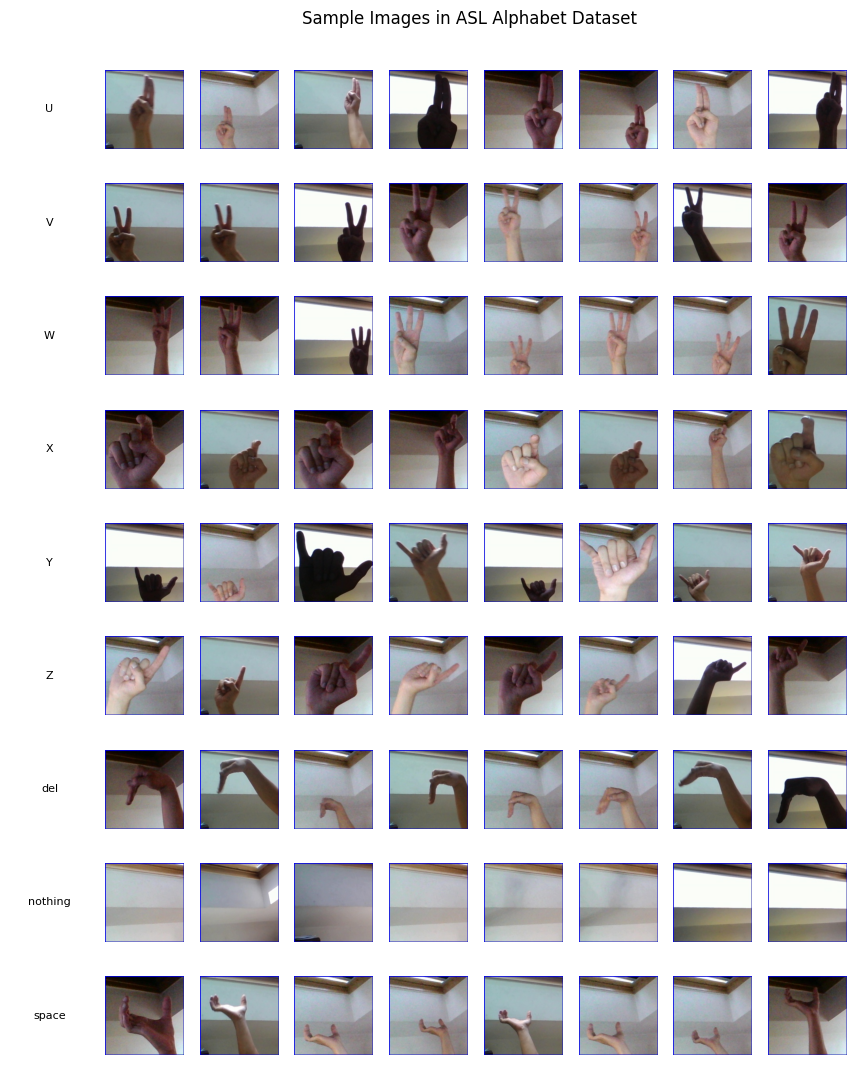

In [9]:
sample_images(labels[20:])

## Build Model

In [10]:
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense

In [11]:
num_classes = len(labels)
input_shape = (32,32,1)

In [12]:
# Build Model
model = models.Sequential()
# 1st convolution layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
# 2nd convolution layer
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
# 3rd convolution layer
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
# fully-connected layers
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

model.summary()

/home/rkuo/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
2024-04-18 03:13:16.116183: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-18 03:13:16.134169: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-18 03:13:16.134269: I e

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 29)             │         3,741 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 359,581 (1.37 MB)

 Trainable params: 359,133 (1.37 MB)

 Non-trainable params: 448 (1.75 KB)

In [13]:
# Compile Model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 

## Train Model

In [14]:
history = model.fit(train_generator, validation_data=val_generator, epochs=50)

Epoch 1/50


/home/rkuo/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1713381197.089774   99019 service.cc:145] XLA service 0x7e6304006e50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1713381197.089788   99019 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2024-04-18 03:13:17.111942: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-18 03:13:17.205080: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


  39/4350 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.0654 - loss: 3.8121     

I0000 00:00:1713381198.199312   99019 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4350/4350 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.5549 - loss: 1.4949 - val_accuracy: 0.7982 - val_loss: 0.6423
Epoch 2/50
4350/4350 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.9313 - loss: 0.2023 - val_accuracy: 0.8541 - val_loss: 0.4856
Epoch 3/50
4350/4350 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.9578 - loss: 0.1248 - val_accuracy: 0.7639 - val_loss: 2.0236
Epoch 4/50
4350/4350 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.9702 - loss: 0.0926 - val_accuracy: 0.9595 - val_loss: 0.1420
Epoch 5/50
4350/4350 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.9763 - loss: 0.0719 - val_accuracy: 0.9015 - val_loss: 0.3271
Epoch 6/50
4350/4350 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.9804 - loss: 0.0630 - val_accuracy: 0.9547 - val_loss: 0.1642
Epoch 7/50
4350/4350 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.9829 - loss: 0.0554 - val_accuracy: 0.9922 - val_loss: 0.0217
Epoch 8/50
4350/4350 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.9850 - loss: 0.0490 - val

4350/4350 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.9966 - loss: 0.0124 - val_accuracy: 0.9971 - val_loss: 0.0079


## Evaluate Model

In [15]:
scores = model.evaluate(test_generator) 
print('Test loss: ', scores[0])
print('Test accuracy: ', scores[1])

544/544 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9972 - loss: 0.0147
Test loss:  0.010830829851329327
Test accuracy:  0.997471272945404


## Save Model

In [16]:
model.save("asl_alphabet_cnn.h5")